# Fake News Detection using Machine Learning & NLP
This notebook demonstrates a complete end-to-end workflow for detecting fake news using text classification.

##  1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import string
import re
import joblib
import os

##  2. Load & Preprocess Dataset

In [2]:
df_fake = pd.read_csv('../data/Fake.csv')
df_real = pd.read_csv('../data/True.csv')

df_fake['label'] = 0
df_real['label'] = 1
df = pd.concat([df_fake, df_real], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

df['content'] = df['title'] + " " + df['text']

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['content'] = df['content'].apply(clean_text)

X = df['content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. TF-IDF Vectorization

In [3]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')

['../models/tfidf_vectorizer.pkl']

## 4. Train Models

In [4]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

joblib.dump(nb_model, '../models/naive_bayes_model.pkl')
joblib.dump(lr_model, '../models/logistic_model.pkl')

['../models/logistic_model.pkl']

## 5. Evaluate Models


Naive Bayes
Accuracy : 0.9354120267260579
Precision: 0.9322867853795689
Recall   : 0.9318501170960187
F1 Score : 0.9320684000936987

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4710
           1       0.93      0.93      0.93      4270

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



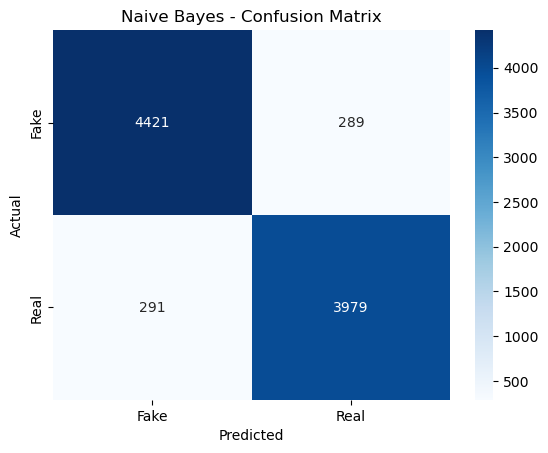


Logistic Regression
Accuracy : 0.9828507795100223
Precision: 0.9799440298507462
Recall   : 0.9840749414519906
F1 Score : 0.9820051413881749

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4710
           1       0.98      0.98      0.98      4270

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



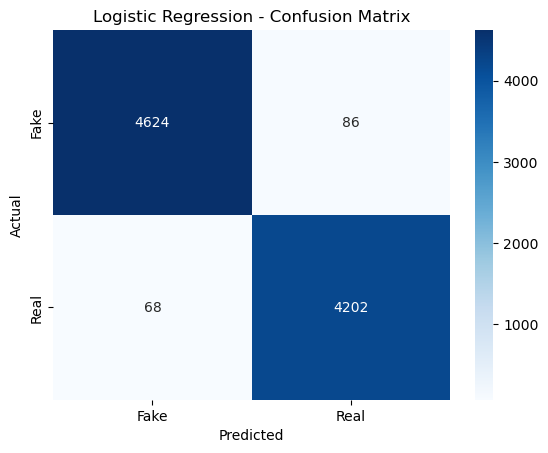

In [5]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Naive Bayes", nb_model, X_test_tfidf, y_test)
evaluate_model("Logistic Regression", lr_model, X_test_tfidf, y_test)

## 6. Summary of Results

| Model              | Accuracy | F1 Score |
|-------------------|----------|----------|
| Naive Bayes        | 93.54% | 93.21% |
| Logistic Regression| 98.26% | 98.02% |

Logistic Regression outperformed Naive Bayes on both accuracy and F1 score, making it the better model for this task.

## 7. WordCloud Visualization

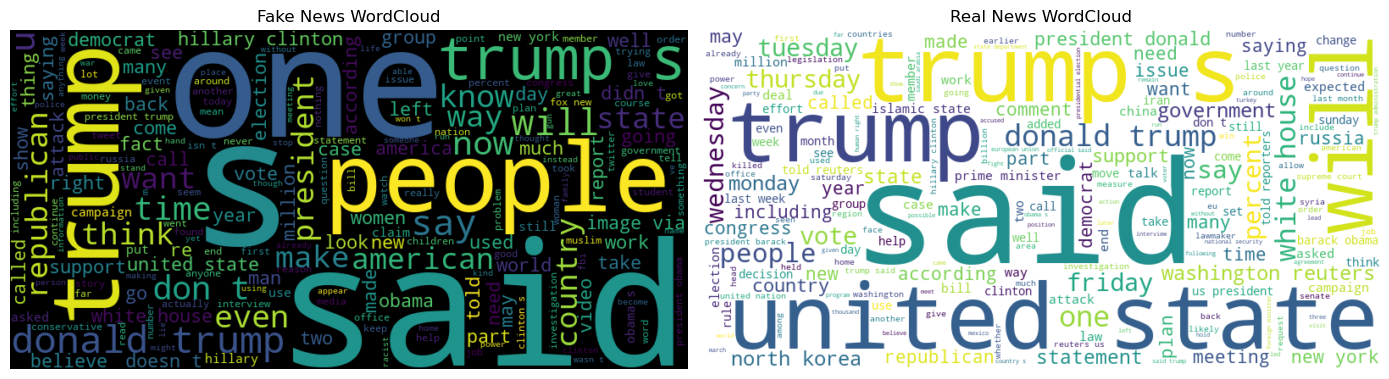

In [6]:
fake_text = " ".join(df[df.label == 0]['content'])
real_text = " ".join(df[df.label == 1]['content'])

fake_wc = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News WordCloud")

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Real News WordCloud")
plt.tight_layout()
plt.show()